Tässä notebookissa toteutetaan aikasarjaennustamista avainsanoille, joiden hakuvolyymin määrä haetaan Google Trends-datasta. Esimerkissä on käytetty avainsanana sanaa "heijastin", mutta sanan voi halutessaan vaihtaa (tällöin toki sanalliset selitteet eivät enää pidä paikkaansa).

Halusin luoda työkalun, josta on oikeasti hyötyä. Työkalua pysty hyödyntämään yrityksen markkinoinnin suunnittelemisessa sekä hakukoneoptimoinnissa, kun voidaan ennustaa, milloin mitäkin avainsanaa todennäköisesti haetaan verkosta eniten.

Google Trends -dataa hyödyntäessä on hyvä pitää mielessä, että data on suhteellista, normalisoitua ja perustuu otoksiin, joten se ei anna tarkkoja hakumääriä. Hakutermien kausivaihtelut, alueellinen tarkkuus ja aikasarjan granulariteetti voivat vaikuttaa datan luotettavuuteen. Google Trends -data antaa hyvän yleiskuvan hakumäärien trendeistä ja muutoksista ajan kuluessa, mutta sitä ei pidä pitää absoluuttisena totuutena. Datan käyttökelpoisuus ja tarkkuus riippuvat useista tekijöistä, kuten normalisoinnista, otoskoosta ja alueellisista eroista. On hyvä käyttää Google Trends -dataa täydentävänä tietolähteenä ja huomioida sen rajoitukset, erityisesti kun tehdään liiketoiminnallisia päätöksiä tai laajoja analyyseja.

# Haetaan tarvittavat kirjastot

In [1]:
# asennetaan Google Trends -kirjasto, joka mahdollistaa Google Trends -tietojen hakemisen ja analysoinnin Pythonilla
!pip install pytrends

In [2]:
# tuodaan tarvittavat kirjastot
from pytrends.request import TrendReq  # pytrends-kirjaston pääluokka, joka mahdollistaa google trends -tietojen haun
import pandas as pd  # pandas-kirjasto datan käsittelyyn ja analysointiin
import matplotlib.pyplot as plt  # matplotlib-kirjasto datan visualisointiin
import matplotlib.dates as mdates  # matplotlibin päivämäärien käsittelymoduuli
import seaborn as sns  # seaborn-kirjasto edistyneempään datan visualisointiin
import plotly.express as px #plotly.express tarjoaa yksinkertaisia ja tehokkaita tapoja luoda monenlaisia kaavioita, kuten viivakaavioita, pylväskaavioita ja lämpökarttoja, jotka ovat helposti mukautettavissa ja joita käyttäjä voi tutkia interaktiivisesti
import plotly.graph_objects as go  # plotly graph objects tarjoaa joustavamman ja yksityiskohtaisemman tavan rakentaa kaavioita ja antaa täyden hallinnan kaavion ulkoasuun ja komponentteihin

from statsmodels.tsa.api import seasonal_decompose  # aikasarjojen kausivaihtelun purkamiseen
from statsmodels.tsa.api import ExponentialSmoothing  # aikasarjan ennustamiseen eksponentiaalista tasoitusta käyttäen

# seabornin ulkoasun asetukset
sns.set_style('whitegrid')

# Haetaan data

In [3]:
# määritetään haettava avainsana, jonka suosittelu- ja hakutiedot haetaan google trendsistä
# avainsanaa voi halutessaan vaihtaa mutta tällöin sanalliset selitteet eivät enää pidä paikkaansa
avainsana = 'heijastin'

# luodaan lista avainsanoista, jotka analysoidaan google trendsissä
kw = [avainsana]

# alustetaan pytrends-objekti ja asetetaan parametrit (määritetään kieli suomeksi ja aikavyöhyke itä-euroopan aikaa vastaavaksi)
trend = TrendReq(hl='fi', tz=180)

# määritetään aikaväli, jolta avainsanojen trenditiedot haetaan (tässä tapauksessa viimeiset 5 vuotta)
trend.build_payload(kw, timeframe='today 5-y')

In [4]:
# luodaan dataframe Google Trends -datan pohjalta
try:
    df = trend.interest_over_time()
    if 'isPartial' in df.columns:
        df = df.drop(columns=['isPartial'], axis=1)
except Exception as e:
    print(f"Virhe tietojen haussa: {e}")
    df = pd.DataFrame()

# varmistetaan, ettei dataframe ole tyhjä ennen jatkamista
if not df.empty:
    # muokataan dataframen indexin otsikko
    df.index.name = 'Aika'

# tulostetaan dataframen ensimmäiset rivit
df.head()

Virhe tietojen haussa: The request failed: Google returned a response with code 429


""


# Datan tarkastelu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2019-10-27 to 2024-10-27
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   heijastin  262 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [ ]:
print(df)

            heijastin
Aika                 
2019-10-27         80
2019-11-03         93
2019-11-10         91
2019-11-17         85
2019-11-24         76
...               ...
2024-09-29         85
2024-10-06         65
2024-10-13         59
2024-10-20         70
2024-10-27         79

[262 rows x 1 columns]


# Tarkastellaan df.info()- ja print(df)-tulosteista saatavia tietoja:
* DatetimeIndex kattaa ajanjakson 20.10.2019 - 20.10.2024.
* DataFramessa on yhteensä 262 riviä, eli 262 eri aikapistettä. Aikavälin tiheys on todennäköisesti viikoittainen, koska viikossa on tyypillisesti 52 viikkoa, ja ajanjakso kattaa noin viisi vuotta.

"heijastin"-sarake:
* Tyyppi on int64, joka viittaa siihen, että sarake sisältää kokonaislukuja.
* Tämä sarake edustaa Google Trends -tietoja hakutermistä "heijastin", ja arvot kertovat hakujen suhteellisen suosion eri ajankohtina asteikolla 0–100.

Aikaleimat:
* Aikaleimat alkavat 20.10.2019 ja päättyvät 20.10.2024. Sarakkeessa "isPartial" näkyy, että viimeisen aikaleiman (2024-10-20) kohdalla arvo on True, mikä viittaa siihen, että kyseinen tieto on osittainen. Tämä saattaa johtua siitä, että kyseinen aikahetki on lähellä nykyhetkeä ja tietoja ei ole vielä täysin kerätty.

In [ ]:
# luodaan viivakaavio käyttäen plotly.graph_objects -kirjastoa
fig = go.Figure()

# lisätään viiva kaavioon avainsanan arvoilla ja ajalla
fig.add_trace(go.Scatter(
    x=df.index,
    y=df[avainsana],
    mode='lines',
    name='Avainsana'
))

# asetetaan kaavion otsikko ja x-akselin sekä y-akselin otsikot
fig.update_layout(
    title=f'Avainsanan "{avainsana}" hakuvolyymit Google Trendsin mukaan',
    xaxis_title="Aikajakso",
    yaxis_title="Hakumäärä",
    xaxis=dict(
        tickformat="%Y-%m",  # muotoillaan x-akselin merkinnät näyttämään vuosi ja kuukausi
        dtick="M6",  # määritellään, että tikkaukset tulevat kuuden kuukauden välein
        tickangle=0,  # pidetään merkinnät suorassa kulmassa paremman luettavuuden varmistamiseksi
    )
)

# näytetään kaavio
fig.show()

"Heijastin"-hakutermin suosio noudattaa vahvaa kausivaihtelua, jossa huippu saavutetaan yleensä syksyllä ja talvella, kun taas kysyntä laskee keväällä ja kesällä.

# Aikasarjaennusteet

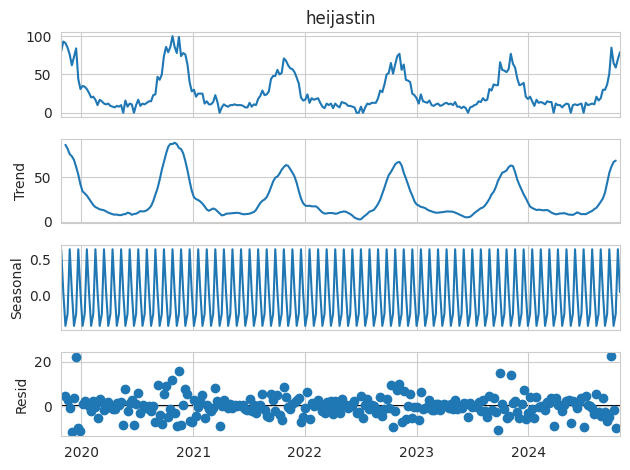

In [ ]:
# tarkastellaan aikasarjojen komponentteja
seasonal_decompose(df[avainsana], model='additive', period=4).plot()
plt.show()

seasonal_decompose()-menetelmä purkaa aikasarjan sen eri komponentteihin: alkuperäinen aikasarja, trendi, kausivaihtelu ja jäännös (residuals).

Kausivaihtelu on selkeä ja toistuva: hakutermin suosio kasvaa selvästi syksyllä ja talvella, kun heijastimien tarve on suurimmillaan. Tämä vahvistaa käsityksen heijastimen kausiluonteisesta kysynnästä.

Trendi osoittaa hieman laskevaa tai tasaantuvaa suuntausta, mikä voi viitata markkinoiden kyllästymiseen tai vähentyneeseen mielenkiintoon.

Jäännöskomponentti on melko satunnainen, mikä tarkoittaa, että malli selittää suurelta osin aikasarjan käyttäytymisen. Mallin selitysvoima on siis hyvä, koska ei ole havaittavissa systemaattisia poikkeamia.

In [ ]:
# Resamplataan data vuosineljänneksen tasolle ja täytetään puuttuvat arvot
# Tämä auttaa käsittelemään puuttuvia arvoja ja saamaan ennustettavan sarjan jatkuvaksi
# Tässä käytetään eteenpäin täyttämistä (forward fill) puuttuvien arvojen täyttämiseksi
df = df.resample('QE').ffill()

# Varmistetaan, että sarjan kaikki arvot ovat positiivisia, jotta multiplikatiivinen kausivaihtelu toimii
# Jos arvo on pienempi tai yhtä suuri kuin nolla, lisätään pieni vakio siirtämään arvoja ylöspäin
df[avainsana] = df[avainsana].where(df[avainsana] > 0, df[avainsana].min() + 1e-6)

# Muodostetaan ennustemalli kolminkertaisella eksponentiaalisella tasoituksella
# Käytetään additiivista trendiä ja additiivista kausivaihtelua, neljännesvuosittaisella kaudella
malli3 = ExponentialSmoothing(df[avainsana], trend='add', seasonal='add', seasonal_periods=4).fit()

Päädyin käyttämään additiivista trendiä ja kausivaihtelua (trend='add', seasonal='add'), koska alkuperäinen malli käytti multiplikatiivista kausivaihtelua (seasonal='mul'), joka ei onnistunut konvergoimaan parametreja kunnolla. Tämä johtui siitä, että data sisälsi nollia ja pieniä arvoja, mikä on ongelmallista multiplikatiiviselle kausivaihtelulle, koska se edellyttää positiivisia arvoja ja suhteellista kausivaihtelua.

Additiivinen kausivaihtelu soveltuu paremmin tilanteisiin, joissa kausivaihtelun suuruus on vakio ajan myötä, ja tässä tapauksessa additiivinen lähestymistapa tuotti paremman optimoinnin ja järkevämmät tulokset

In [ ]:
# lisätään alkuperäiseen dataframeen uusi muuttuja, joka kuvaa mallin ennustamaa kysyntää
df['Ennuste'] = malli3.fittedvalues
df.head()

,heijastin,Ennuste
Aika,,
2019-12-31,31.0,30.761631
2020-03-31,12.0,16.767473
2020-06-30,10.0,7.843206
2020-09-30,74.0,63.692568
2020-12-31,28.0,47.716503


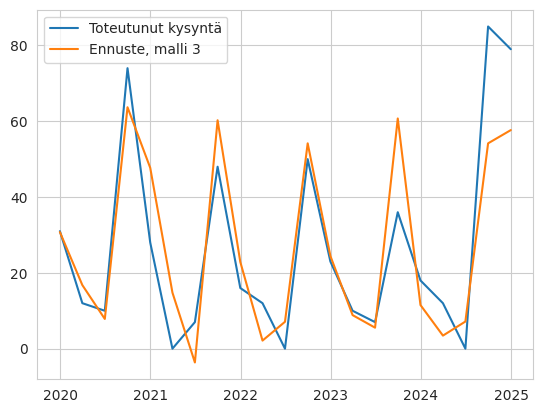

In [ ]:
# piirretään samaan kuvaan sekä toteutuneet että mallin mukaiset arvot
plt.plot(df.index, df[avainsana], label='Toteutunut kysyntä')
plt.plot(df.index, df['Ennuste'], label='Ennuste, malli 3')
plt.legend()

Vaikka malli pystyy ennustamaan tiettyjä piirteitä datasta, se ei näytä toimivan luotettavasti kaikilla aikajaksoilla, erityisesti ennustejakson myöhemmässä vaiheessa.

## Mallin hyvyyden tarkastelu

In [ ]:
# lisätään ennustevirheet dataframeen
df['Ennustevirhe'] = malli3.resid
df.head()

,heijastin,Ennuste,Ennustevirhe
Aika,,,
2019-12-31,31.0,30.761631,0.238369
2020-03-31,12.0,16.767473,-4.767473
2020-06-30,10.0,7.843206,2.156794
2020-09-30,74.0,63.692568,10.307432
2020-12-31,28.0,47.716503,-19.716503


Text(0, 0.5, 'Ennustevirhe')

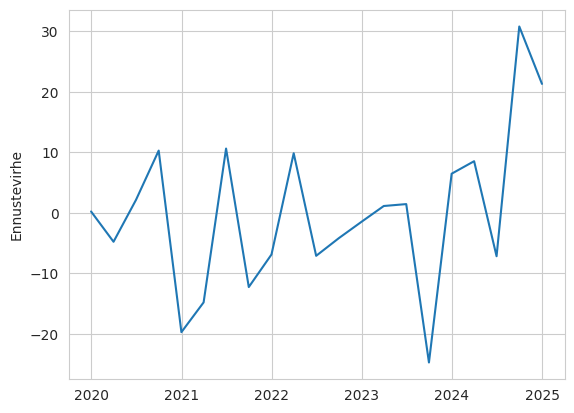

In [ ]:
# tarkastellaan graafisesti ennustevirhettä
plt.plot(df.index, df['Ennustevirhe'])
plt.ylabel('Ennustevirhe')

Virheiden vaihtelevuus: Ennustevirheessä on selkeää vaihtelua, mikä tarkoittaa, että malli ei aina osunut tarkasti toteutuneisiin arvoihin. Virheiden suuret piikit osoittavat ajanjaksoja, joissa mallin ennusteet olivat erityisen kaukana toteutuneista arvoista. Tämä voi viitata siihen, että mallin kyky ottaa huomioon tiettyjä markkinaolosuhteita tai muita ulkoisia tekijöitä on rajallinen.

Kausiluonteisuus: Ennustevirhe näyttää seuraavan jonkinlaista kausittaista vaihtelua. Tämä voi tarkoittaa, että mallilla on vaikeuksia ennustaa kausivaihteluun liittyviä piirteitä oikein tai että malli ei täysin onnistu kausivaihtelun tarkassa mallintamisessa. Kausivaihtelun tunnistaminen virheistä voi antaa viitteitä siitä, että mallia voisi parantaa paremmin huomioimaan kausittaiset vaihtelut.

Yleisvirheiden suuruus: Virheiden arvot vaihtelevat positiivisesta negatiiviseen, mikä tarkoittaa, että malli sekä yliarvioi että aliarvioi kysyntää eri ajanjaksoina. Mallin systemaattinen virhe (esimerkiksi jatkuva yliarviointi tai aliarviointi) voisi kertoa ennustemallin rakenteellisesta virheestä, mutta tässä tapauksessa virheet vaihtelevat kummankin suunnan välillä.

Erityiset piikit: Joillakin ajanjaksoilla, kuten vuoden 2021 alussa ja vuoden 2024 lopussa, virheet ovat erityisen suuria. Tämä voi johtua poikkeuksellisista tapahtumista, joita malli ei pystynyt ennakoimaan, kuten äkilliset markkinamuutokset tai muut ulkoiset tekijät, jotka eivät noudata historiallista trendiä tai kausiluonteisuutta.

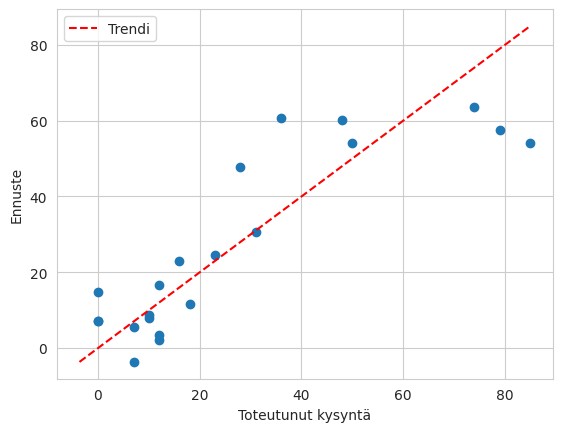

In [ ]:
# verrataan hajontakuviolla toteutuneita arvoja ennusteisiin:
plt.scatter(df[avainsana], df['Ennuste'])
plt.xlabel('Toteutunut kysyntä')
plt.ylabel('Ennuste')

# Määritetään trendiviivan aloitus- ja lopetuskohdat dynaamisesti
min_value = min(df[avainsana].min(), df['Ennuste'].min())
max_value = max(df[avainsana].max(), df['Ennuste'].max())

# Piirretään trendiviiva dynaamisilla aloitus- ja lopetuskohdilla
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Trendi')

plt.legend()
plt.show()

Yleisesti ottaen voidaan päätellä, että malli pystyy kohtuullisesti seuraamaan trendiä, mutta siinä on huomattavia poikkeamia, jotka osoittavat, että ennustemallia voitaisiin parantaa tarkkuuden lisäämiseksi. Esimerkiksi lisäparametrien optimointi tai datan ennakkokäsittelyn parantaminen voisi auttaa vähentämään hajontaa ja parantamaan mallin suorituskykyä.

In [ ]:
# yleisemmin statistiikkaa
malli3.summary()

Dep. Variable:,heijastin,No. Observations:,21
Model:,ExponentialSmoothing,SSE,3406.260
Optimized:,True,AIC,122.866
Trend:,Additive,BIC,131.222
Seasonal:,Additive,AICC,144.866
Seasonal Periods:,4,Date:,"Tue, 29 Oct 2024"
Box-Cox:,False,Time:,16:09:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9486817,alpha,True
smoothing_trend,0.000000,beta,True


Kuvassa näkyvä SSE (Sum of Squared Errors) eli neliösummavirhe on tärkeä mittari ennustemallien arvioinnissa. Se edustaa mallin virheen neliöiden summaa, eli kuinka kaukana mallin ennusteet ovat todellisista arvoista. Mitä suurempi SSE on, sitä suurempia mallin tekemät virheet ovat.

Kuvassa SSE-arvo on 5598.297, mikä viittaa siihen, että mallin virheet eivät ole pieniä, ja mallin ennustama kysyntä ei aina vastaa todellisia arvoja tarkasti. Tämän arvon tulkinta kuitenkin riippuu siitä, kuinka suuria alkuperäiset havaintoarvot ovat ja kuinka suuri virhe on suhteessa niihin. Jos SSE on korkea, se saattaa viitata siihen, että mallia pitäisi parantaa, esimerkiksi muuttamalla parametrien arvoja tai valitsemalla toinen malli.

In [ ]:
# viimeinen aikaleima
df.tail()

,heijastin,Ennuste,Ennustevirhe
Aika,,,
2023-12-31,18.000000,11.514140,6.485860
2024-03-31,12.000000,3.447152,8.552848
2024-06-30,0.000001,7.159866,-7.159865
2024-09-30,85.000000,54.170112,30.829888
2024-12-31,79.000000,57.663464,21.336536


In [ ]:
# luodaan aikaleimat seuraaville kahdeksalle vuosineljännekselle (2025-01-01 ->)
aikaleimat = pd.date_range('2025-01-01',periods=8, freq='QE')

In [ ]:
# lasketaan ennusteet
ennusteet3 = malli3.forecast(8)

In [ ]:
# muodostetaan ennusteille oma dataframe
ennusteet3 = pd.DataFrame(ennusteet3, index=aikaleimat, columns=['Ennuste'])
ennusteet3

,Ennuste
2025-03-31,63.685071
2025-06-30,59.283618
2025-09-30,113.086869
2025-12-31,87.332007
2026-03-31,73.112033
2026-06-30,68.710581
2026-09-30,122.513831
2026-12-31,96.758970


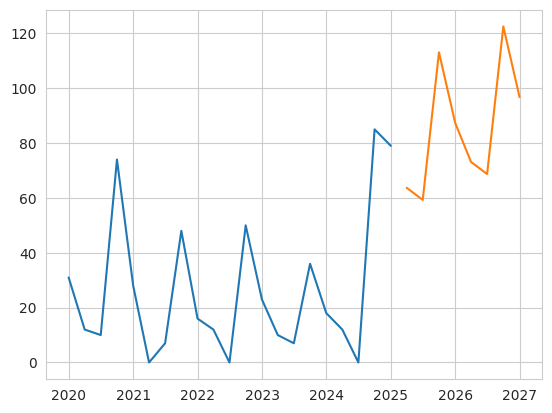

In [ ]:
# piirretään samaan kaavioon sekä ennustetut että toteutuneet arvot
plt.plot(df.index, df[avainsana])
plt.plot(ennusteet3.index, ennusteet3['Ennuste'])

Ennusteen kasvu: Oranssi viiva on merkittävästi korkeammalla kuin historialliset toteutuneet arvot. Tämä voi viitata siihen, että malli olettaa kysynnän kasvavan tulevaisuudessa. Tämä voi johtua siitä, että trendikomponentti on asetettu additiiviseksi, jolloin malli saattaa ylikorostaa aiempaa kasvutrendiä.

Kausiluonteisuus: Ennustetut arvot osoittavat selkeän kausivaihtelun jatkumista, mikä viittaa siihen, että malli on oppinut menneisyyden kausivaihtelun ja ennustaa sen jatkuvan tulevaisuudessa samalla tavalla.
Mallin käyttäytyminen: Koska ennustettu taso on huomattavasti korkeampi, on hyvä arvioida, onko tämä realistista, vai johtuuko tämä mallin rakenteesta ja parametrien optimoinnista. Tämä saattaa viitata siihen, että malli on liian optimistinen tulevaisuuden kysynnän suhteen.

# Tarkastellaan, millaiset ennusteet oltaisiin saatu, mikäli oltaisiin käytetty yksinkertaista tai kaksinkertaista eksponentiaalista tasoitusta

In [ ]:
# muodostetaan mallit
malli1 = ExponentialSmoothing(df[avainsana], freq='QE').fit()
malli2 = ExponentialSmoothing(df[avainsana], trend='add', freq='QE').fit()

In [ ]:
# lisätään dataframeen df näiden mallien mukaiset ennusteet
df['Ennuste, malli 1'] = malli1.fittedvalues
df['Ennuste, malli 2'] = malli2.fittedvalues
df.head()

,heijastin,Ennuste,Ennustevirhe,"Ennuste, malli 1","Ennuste, malli 2"
Aika,,,,,
2019-12-31,31.0,30.761631,0.238369,26.572688,17.727254
2020-03-31,12.0,16.767473,-4.767473,26.574618,18.611673
2020-06-30,10.0,7.843206,2.156794,26.568266,19.496090
2020-09-30,74.0,63.692568,10.307432,26.561045,20.380507
2020-12-31,28.0,47.716503,-19.716503,26.581720,21.264929


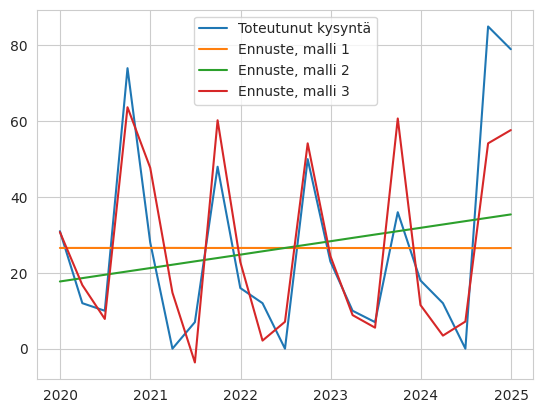

In [ ]:
# piirretään samaan kuvioon toteutuneet arvot sekä jokaisen mallin mukaiset arvot
plt.plot(df.index, df[avainsana], label='Toteutunut kysyntä')
plt.plot(df.index, df['Ennuste, malli 1'], label='Ennuste, malli 1')
plt.plot(df.index, df['Ennuste, malli 2'], label='Ennuste, malli 2')
plt.plot(df.index, df['Ennuste'], label='Ennuste, malli 3')
plt.legend()

In [ ]:
malli1.summary()

Dep. Variable:,heijastin,No. Observations:,21
Model:,ExponentialSmoothing,SSE,13805.150
Optimized:,True,AIC,140.254
Trend:,None,BIC,142.343
Seasonal:,None,AICC,142.754
Seasonal Periods:,None,Date:,"Tue, 29 Oct 2024"
Box-Cox:,False,Time:,16:09:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0004358,alpha,True
initial_level,26.572688,l.0,True


malli1:

SSE (14108.667): Tämä arvo kuvaa mallin virheiden neliöiden summaa, eli kuinka paljon mallin ennusteet poikkeavat toteutuneista arvoista. Suurempi SSE-arvo viittaa siihen, että ennustemalli ei ole kovin tarkka ja sisältää enemmän poikkeamia toteutuneista arvoista.

In [ ]:
malli2.summary()

Dep. Variable:,heijastin,No. Observations:,21
Model:,ExponentialSmoothing,SSE,13196.857
Optimized:,True,AIC,143.307
Trend:,Additive,BIC,147.486
Seasonal:,None,AICC,149.307
Seasonal Periods:,None,Date:,"Tue, 29 Oct 2024"
Box-Cox:,False,Time:,16:09:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,9.0151e-08,alpha,True
smoothing_trend,4.1731e-12,beta,True


malli2:

SSE (13565.019): SSE on pienempi kuin mallissa 1, mikä tarkoittaa, että malli2 tuottaa ennusteet, jotka ovat lähempänä todellisia arvoja. Tämä viittaa siihen, että mallin tarkkuus on parantunut.

In [ ]:
# tarkastellaan mallin 2 virhettä
df['malli 2, virhe'] = malli2.resid

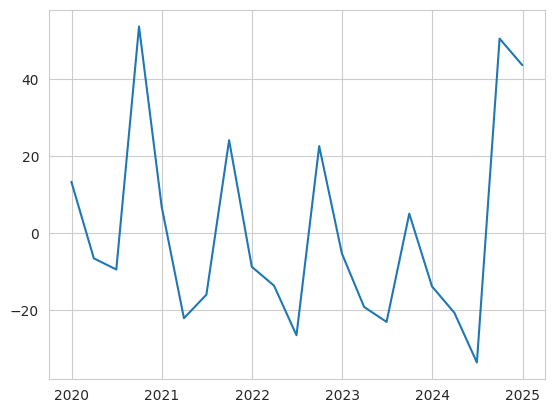

In [ ]:
# muodostetaan vastaava kuvaaja
plt.plot(df.index, df['malli 2, virhe'])

Tässä havaitaan säännöllisyyttä (kausivaihtelua). Tämä kertoo siitä, että kyseinen malli ei huomioi kaikkia alkuperäisen aikasarjan ominaisuuksia

# Ennusteiden laskeminen yksinkertaisen ja kaksinkertaisen eksponentiaalisen tasoituksen avulla

In [ ]:
# lasketaan ennusteet tulevillle kahdeksalle aikaleimalle
ennusteet1 = malli1.forecast(8)
ennusteet2 = malli2.forecast(8)

# muodostetaan näistä omat dataframet:
ennusteet1 = pd.DataFrame(ennusteet1, index=aikaleimat, columns=['Ennuste'])
ennusteet2 = pd.DataFrame(ennusteet2, index=aikaleimat, columns=['Ennuste'])

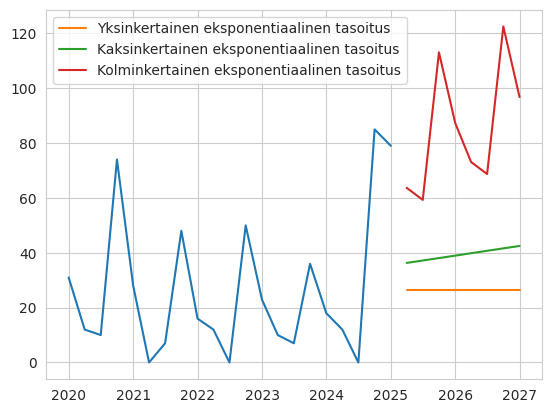

In [ ]:
# piirretään samaan kaavioon kaikkien kolmen mallin ennusteet
plt.plot(df.index, df[avainsana])
plt.plot(ennusteet1.index, ennusteet1['Ennuste'], label='Yksinkertainen eksponentiaalinen tasoitus')
plt.plot(ennusteet2.index, ennusteet2['Ennuste'], label='Kaksinkertainen eksponentiaalinen tasoitus')
plt.plot(ennusteet3.index, ennusteet3['Ennuste'], label='Kolminkertainen eksponentiaalinen tasoitus')
plt.legend()

 Tässä tapauksessa kolminkertainen tasoitus näyttää mallintavan sekä trendiä että kausivaihtelua, mutta sen ennusteiden korkeus herättää kysymyksiä siitä, onko malli realistinen.

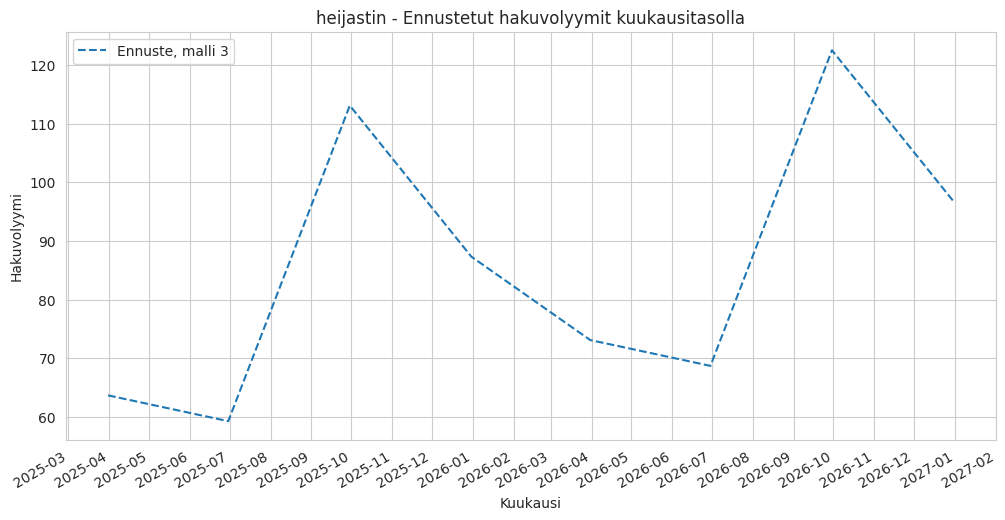

In [ ]:
# lisätään ennusteet alkuperäiseen dataframeen, jotta kaikki arvot ovat yhdessä paikassa
df = ennusteet3

# piirretään tulevien kuukausien ennusteet kuukausitasolla
fig, ax = plt.subplots(figsize=(12, 6)) # Create fig and ax using subplots
plt.plot(df.index, df['Ennuste'], label='Ennuste, malli 3', linestyle='--')
plt.xlabel('Kuukausi')
plt.ylabel('Hakuvolyymi')
plt.title(f'{avainsana} - Ennustetut hakuvolyymit kuukausitasolla')
plt.legend()

# Muotoillaan x-akseli näyttämään kuukaudet
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Asetetaan kuukauden välein tärkeimmät merkinnät
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Muotoillaan otsikot muotoon 'YYYY-MM'

fig.autofmt_xdate()  # Automaattinen päivämääräotsikoiden muotoilu luettavuuden parantamiseksi
plt.show()

Datasta voidaan päätellä, että heinäkuun ja huhtikuun välisenä aikana heijastimia haetaan Googlesta eniten, ja kauden huippu on todennäköisesti lokakuussa.

Kaavion ennusteiden avulla voidaan tunnistaa selkeitä kausivaihteluita ja huippuja tulevassa hakuvolyymissa. Tämä tieto voi olla erittäin hyödyllinen markkinoinnin suunnittelussa. Markkinointikampanjoita voidaan kohdentaa ajankohtiin, jolloin kuluttajien kiinnostus (hakuvolyymi) on suurimmillaan, mikä lisää kampanjoiden tehokkuutta. Samalla voidaan optimoida markkinointibudjetti niin, että panostetaan enemmän kausivaihteluiden huippuaikoina. Ennustekaavio auttaa myös suunnittelemaan varastointia ja saatavuutta siten, että kysyntään vastataan paremmin, ja sisältöä voidaan räätälöidä vastaamaan ennustettua kuluttajakäyttäytymistä.